In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx

# Loading the shapefiles 
precincts_parties = gpd.read_file("ny_2022_gen_prec_PARTIES.shp")
precincts = gpd.read_file("ny_2022_gen_prec.shp")

# Filtering to isolate precincts within Congressional District NY-12
district_12_precincts = precincts_parties[precincts_parties["CONG_DIST"] == "12"].copy()
district_12 = precincts[precincts["CONG_DIST"] == "12"]

# Reprojecting precincts to EPSG:3857 for accurate spatial analysis
precincts = precincts.to_crs(epsg=3857)
district_12_precincts = district_12_precincts.to_crs(epsg=3857)
district_12 = district_12.to_crs(epsg=3857)

# Fixing invalid geometries 
precincts["geometry"] = precincts.geometry.buffer(0)


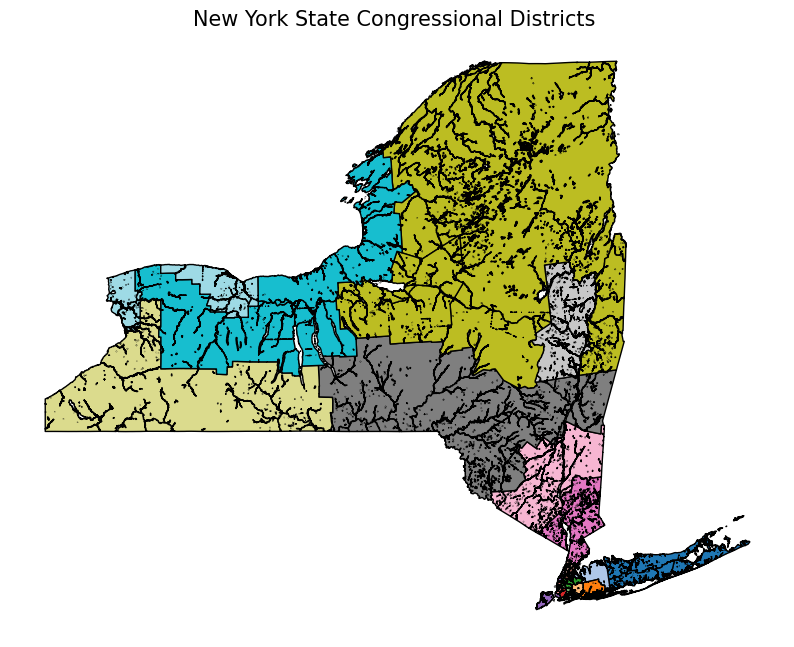

In [2]:
# Plot 1: Plotting each district in a unique color with boundaries

# Dissolving precincts by 'CONG_DIST' to merge precincts into single polygons per district
district_boundaries = precincts.dissolve(by="CONG_DIST")

# Plotting each district with boundaries
fig, ax = plt.subplots(figsize=(10, 10))
district_boundaries.plot(
    ax=ax,
    cmap="tab20",  # Distinct colors for each district
    edgecolor="black",  # Boundary color
    linewidth=1  # Boundary line width 
)
ax.set_title("New York State Congressional Districts ", fontsize=15)
ax.axis("off")  
plt.show()


In [3]:
# Plot 2: Plotting all precincts within each congressional district

# Assigning uniform colors per district 
precincts["CONG_DIST"] = precincts["CONG_DIST"].astype(str)

# Creating an adjacency graph of districts for color assignment
graph = nx.Graph()
for district_id in precincts["CONG_DIST"].unique():
    district_precincts = precincts[precincts["CONG_DIST"] == district_id]
    for i, geom in district_precincts.iterrows():
        neighbors = precincts[precincts.geometry.touches(geom.geometry)]
        for j in neighbors.index:
            neighbor_district = precincts.at[j, "CONG_DIST"]
            if district_id != neighbor_district:
                graph.add_edge(district_id, neighbor_district)

# Assigning unique colors to each district 
district_colors = nx.coloring.greedy_color(graph, strategy="largest_first")
color_list = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']
cmap = ListedColormap(color_list)

# Mapping colors back to precincts based on districts
precincts["color"] = precincts["CONG_DIST"].map(lambda dist: color_list[district_colors[dist]])


fig, ax = plt.subplots(figsize=(10, 10))
precincts.plot(ax=ax, color=precincts["color"], edgecolor="black", linewidth=0.2)
ax.set_title("New York State Precincts within each congressional district ", fontsize=15)
ax.axis("off")  
plt.show()

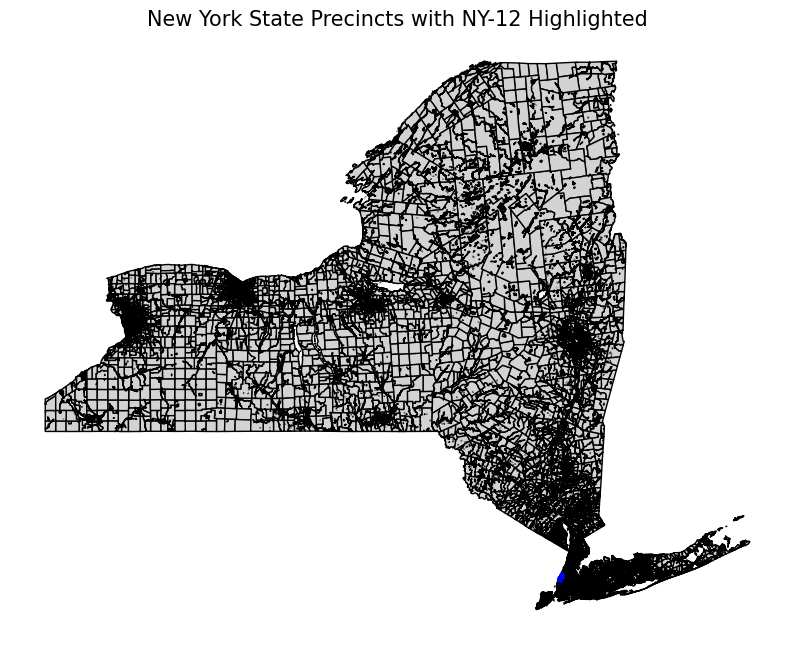

In [4]:
# Plot 3: Plotting all precincts in New York State with District 12 highlighted
fig, ax = plt.subplots(figsize=(10, 10))
precincts.plot(ax=ax, color="lightgrey", edgecolor="black")
district_12.plot(ax=ax, color="red", edgecolor="blue")
ax.set_title("New York State Precincts with NY-12 Highlighted",fontsize=15)
ax.axis("off")
plt.show()


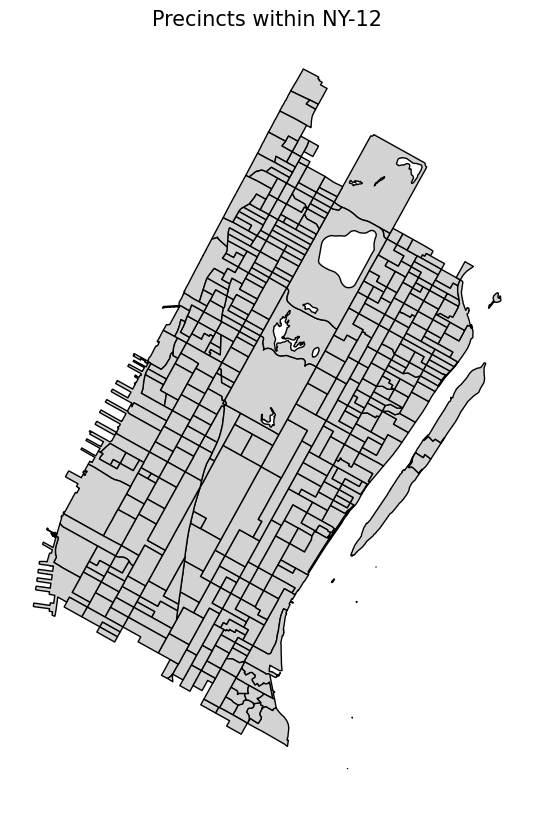

In [5]:
# Plot 4: Plotting only the precincts within NY-12
fig, ax = plt.subplots(figsize=(10, 10))
district_12.plot(ax=ax, color="lightgrey", edgecolor="black")
ax.set_title("Precincts within NY-12",fontsize=15)
ax.axis("off")
plt.show()

In [6]:
# Plot 5: Comparison of Democratic and Republican votes for lower house race in NY-12

# Adding columns for Democratic and Republican votes in the House race
district_12_precincts["House_Dem_Votes"] = district_12_precincts["GCON12DNAD"]
district_12_precincts["House_Rep_Votes"] = district_12_precincts["GCON12RZUM"]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plotting Democratic votes for House race in NY-12 precincts
district_12_precincts.plot(
    column="House_Dem_Votes",
    cmap="Blues",
    legend=True,
    ax=axs[0],
    edgecolor="black"
)
axs[0].set_title("House Race (Democratic Votes) - NY-12 Precincts",fontsize=15)

# Plotting Republican votes for House race in NY-12 precincts
district_12_precincts.plot(
    column="House_Rep_Votes",
    cmap="Reds",
    legend=True,
    ax=axs[1],
    edgecolor="black"
)
axs[1].set_title("House Race (Republican Votes) - NY-12 Precincts",fontsize=15)

plt.tight_layout()
plt.show()


In [7]:
# Plot 6: Plotting the winning party by precinct within NY-12
# Determine the winning party in each precinct by comparing Democratic and Republican votes
district_12_precincts["Winner"] = district_12_precincts.apply(
    lambda row: "Democratic" if row["House_Dem_Votes"] > row["House_Rep_Votes"]
    else "Republican" if row["House_Dem_Votes"] < row["House_Rep_Votes"]
    else "Neutral",
    axis=1
)

# Defining colors for each winner category
colors = {"Democratic": "blue", "Republican": "red", "Neutral": "gray"}

# Plotting the winner for each precinct within NY-12
fig, ax = plt.subplots(figsize=(10, 10))
district_12_precincts.plot(
    color=district_12_precincts["Winner"].map(colors),
    ax=ax,
    edgecolor="black",
    linewidth=0.5
)
# Outlining neutral precincts
district_12_precincts[district_12_precincts["Winner"] == "Neutral"].plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.5,
    facecolor="none"
)

ax.set_title("Precinct-Level House Race Winners in NY-12",fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

In [8]:
# Plot 7: Plotting only the neutral or tied precincts in NY-12
fig, ax = plt.subplots(figsize=(10, 10))
neutral_precincts = district_12_precincts[district_12_precincts["Winner"] == "Neutral"]
neutral_precincts.plot(ax=ax, color="gray", edgecolor="black")
ax.set_title("Neutral or Tied Precincts in NY-12",fontsize=15)
ax.axis("off")
plt.show()


In [9]:
# Printing summary and list of geographic identifiers for neutral precincts
num_dem_wins = (district_12_precincts["Winner"] == "Democratic").sum()
num_rep_wins = (district_12_precincts["Winner"] == "Republican").sum()
num_neutral = (district_12_precincts["Winner"] == "Neutral").sum()

print(f"Number of precincts where Democratic candidate won: {num_dem_wins}")
print(f"Number of precincts where Republican candidate won: {num_rep_wins}")
print(f"Number of precincts with a tie or neutral: {num_neutral}")

print("\nList of Neutral Precincts and the geographic identifiers:")
print(neutral_precincts["GEOID"])


Number of precincts where Democratic candidate won: 371
Number of precincts where Republican candidate won: 0
Number of precincts with a tie or neutral: 18

List of Neutral Precincts and the geographic identifiers:
6779    360610066078
6827    360610067046
6850    360610067072
6922    360610068076
6982    360610069054
6983    360610069055
7008    360610069083
7283    360610073071
7346    360610074063
7350    360610074068
7351    360610074069
7369    360610075019
7417    360610075067
7418    360610075068
7482    360610076065
7483    360610076067
7484    360610076068
7485    360610076069
Name: GEOID, dtype: object


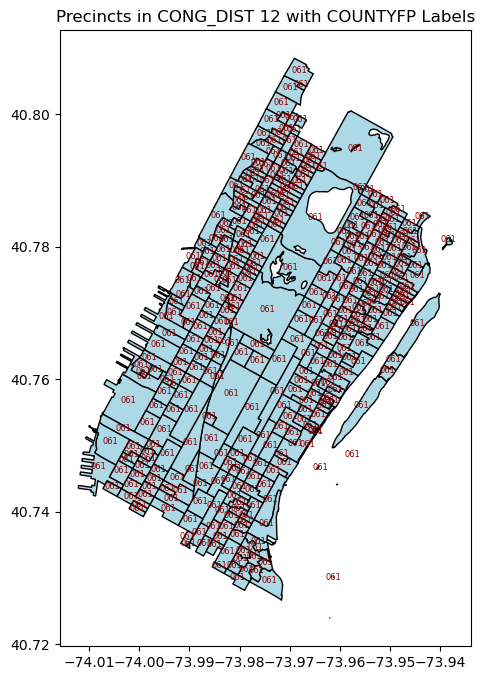

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate and filter the data for CONG_DIST 12
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

district_12 = gdf[gdf['CONG_DIST'] == '12']

# Check for empty results
if district_12.empty:
    print("No precincts found for CONG_DIST 12.")
else:
    # Plot precincts with COUNTYFP labels
    fig, ax = plt.subplots(figsize=(12, 8))
    district_12.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in district_12.iterrows():
        if not row.geometry.is_empty:
            centroid = row.geometry.centroid
            plt.text(centroid.x, centroid.y, str(row['COUNTYFP']), fontsize=6, ha='center', color='darkred')

    plt.title("Precincts in CONG_DIST 12 with COUNTYFP Labels")
    plt.show()


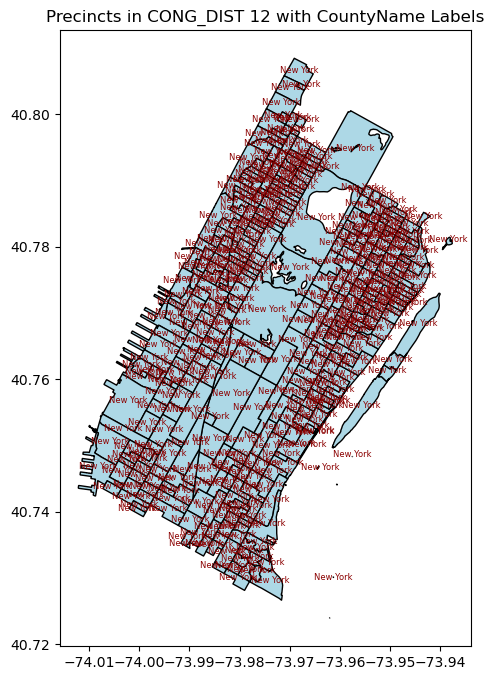

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate and filter the data for CONG_DIST 12
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid
district_12 = gdf[gdf['CONG_DIST'] == '12']

# Check for empty results
if district_12.empty:
    print("No precincts found for CONG_DIST 12.")
else:
    # Plot precincts with CountyName labels
    fig, ax = plt.subplots(figsize=(12, 8))
    district_12.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in district_12.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CountyName at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CountyName']), 
                     fontsize=6, ha='center', color='darkred')

    plt.title("Precincts in CONG_DIST 12 with CountyName Labels")
    plt.show()


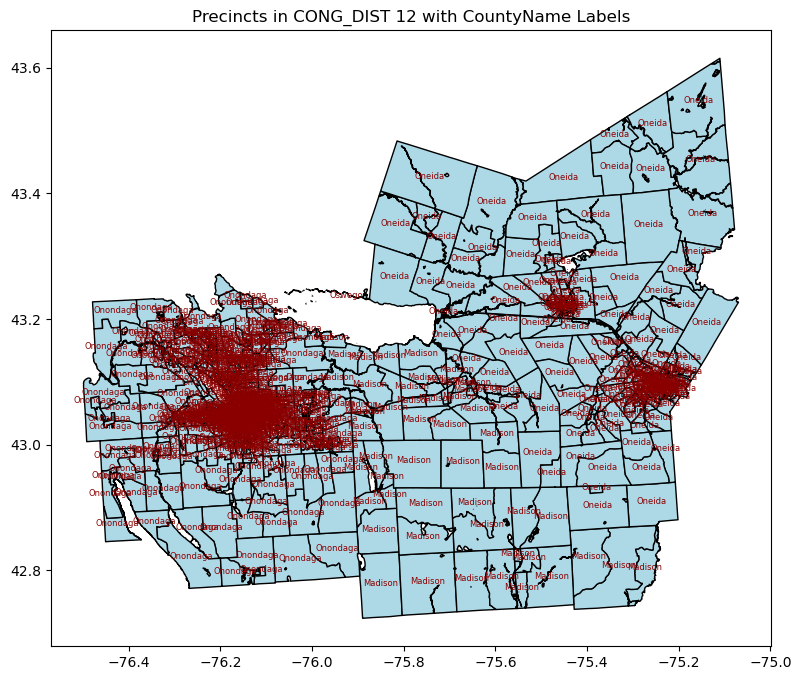

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate and filter the data for CONG_DIST 12
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid
district_12 = gdf[gdf['CONG_DIST'] == '22']

# Check for empty results
if district_12.empty:
    print("No precincts found for CONG_DIST 12.")
else:
    # Plot precincts with CountyName labels
    fig, ax = plt.subplots(figsize=(12, 8))
    district_12.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in district_12.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CountyName at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CountyName']), 
                     fontsize=6, ha='center', color='darkred')

    plt.title("Precincts in CONG_DIST 12 with CountyName Labels")
    plt.show()


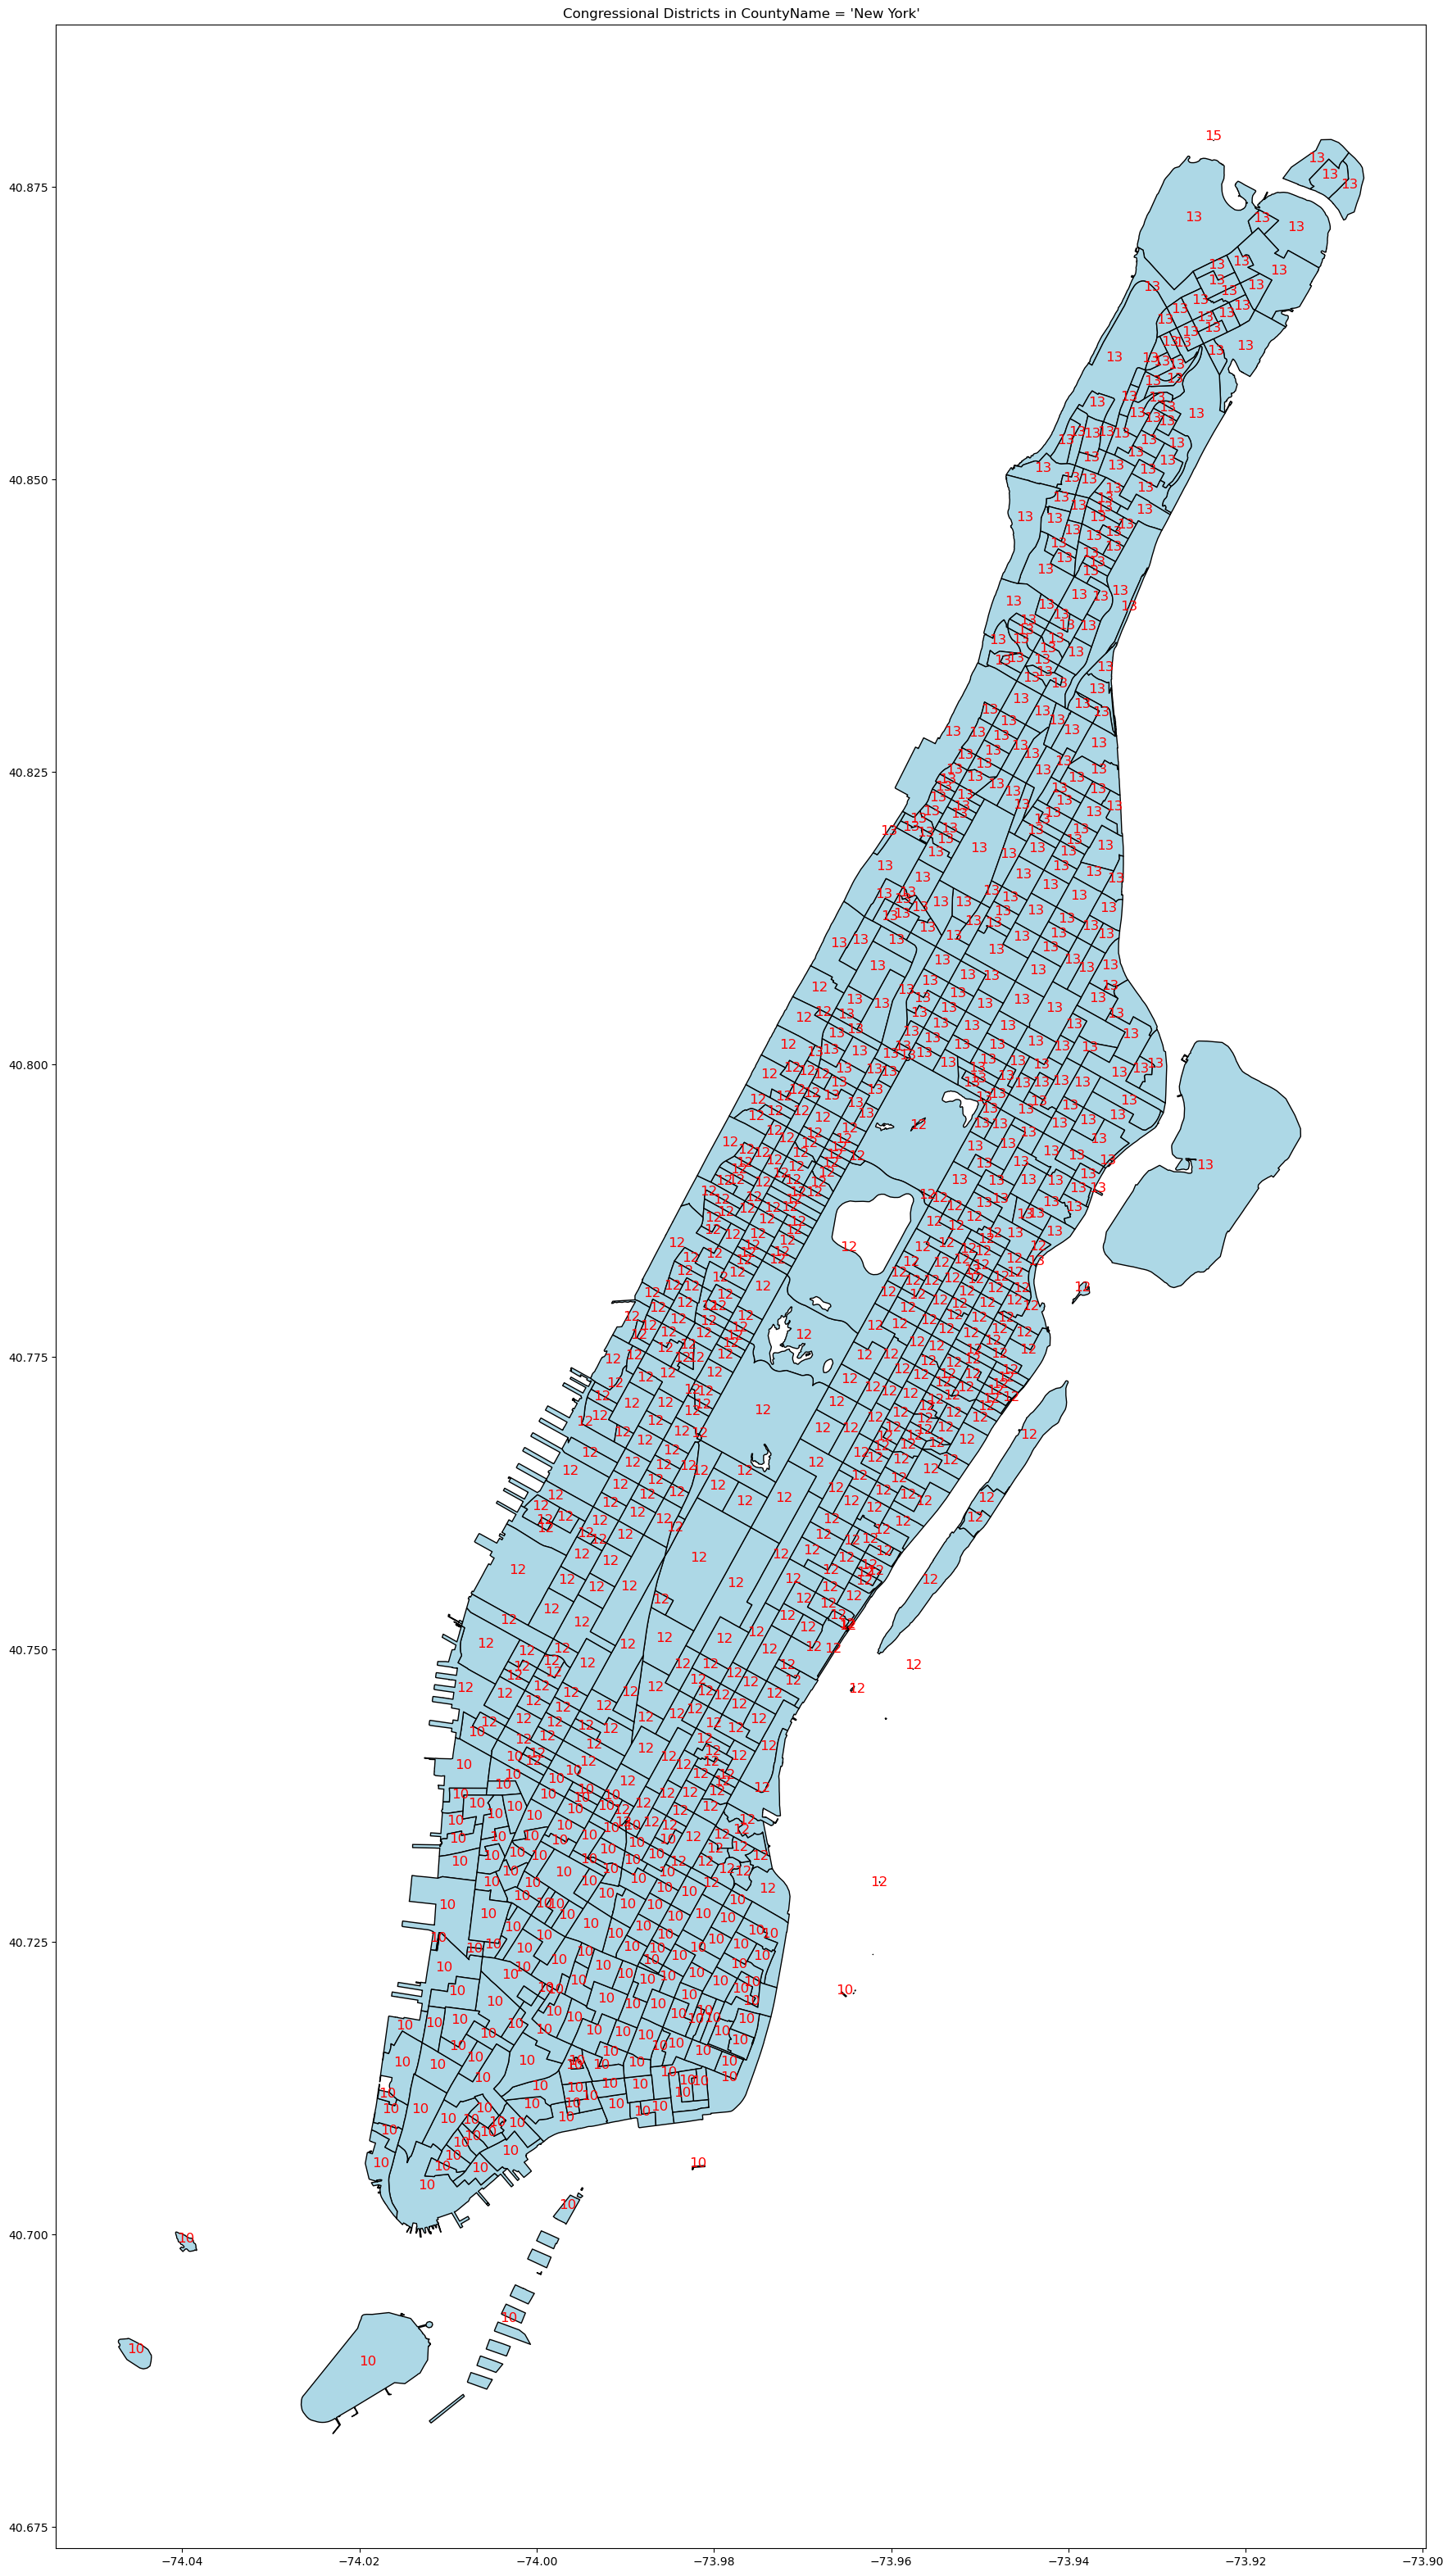

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate geometries
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid

# Filter for CountyName = 'New York'
new_york_county = gdf[gdf['CountyName'] == 'New York']

# Check for empty results
if new_york_county.empty:
    print("No precincts found for CountyName = 'New York'.")
else:
    # Plot the precincts with CONG_DIST labels
    fig, ax = plt.subplots(figsize=(40, 40))
    new_york_county.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in new_york_county.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CONG_DIST at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CONG_DIST']), 
                     fontsize=12, ha='center', color='red')

    plt.title("Congressional Districts in CountyName = 'New York'")
    plt.show()


/var/folders/4w/5mb74rx152dc7knnw3zmr5j00000gn/T/ipykernel_31947/735073197.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_york_county['area'] = new_york_county.geometry.area  # Area in CRS units (e.g., square meters)
/Users/gvsprudhulamouktik/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Proportions of Congressional Districts in CountyName = 'New York':
CONG_DIST
10    20.915491
12    42.249525
13    36.834982
15     0.000003
Name: area, dtype: float64


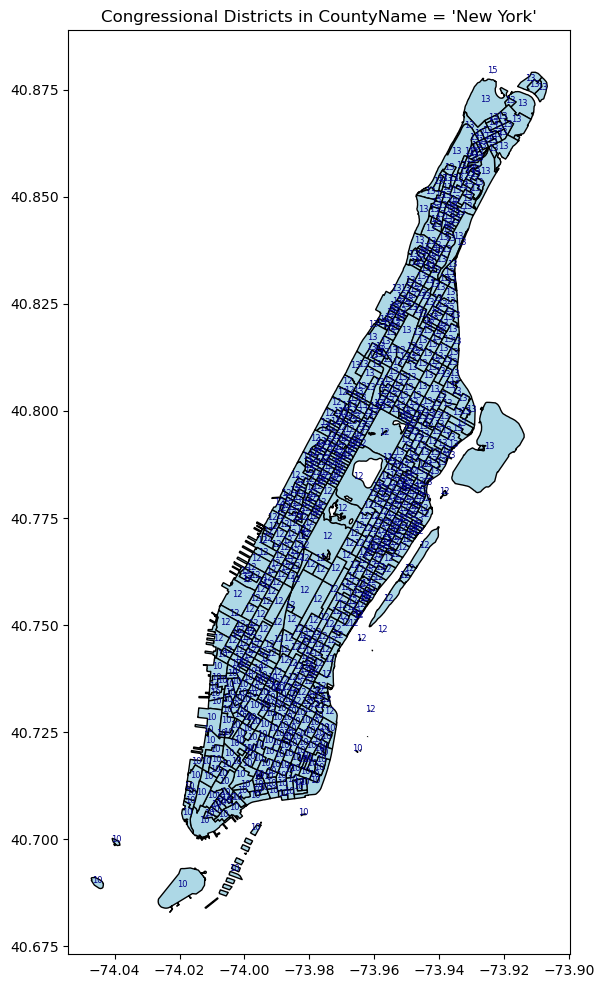

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate geometries
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid

# Filter for CountyName = 'New York'
new_york_county = gdf[gdf['CountyName'] == 'New York']

# Check for empty results
if new_york_county.empty:
    print("No precincts found for CountyName = 'New York'.")
else:
    # Calculate areas for each precinct
    new_york_county['area'] = new_york_county.geometry.area  # Area in CRS units (e.g., square meters)
    
    # Aggregate area by CONG_DIST
    district_areas = new_york_county.groupby('CONG_DIST')['area'].sum()
    total_area = district_areas.sum()
    
    # Calculate proportions
    district_proportions = (district_areas / total_area) * 100
    
    # Print results
    print("Proportions of Congressional Districts in CountyName = 'New York':")
    print(district_proportions)
    
    # Plot the precincts with CONG_DIST labels
    fig, ax = plt.subplots(figsize=(12, 12))
    new_york_county.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in new_york_county.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CONG_DIST at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CONG_DIST']), 
                     fontsize=6, ha='center', color='darkblue')

    plt.title("Congressional Districts in CountyName = 'New York'")
    plt.show()


/Users/gvsprudhulamouktik/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Total Votes in CountyName = 'New York': 1966
Vote Proportions by Congressional District:
CONG_DIST
10    19.888098
12    20.905392
13    59.206511
15     0.000000
Name: TotalVotes, dtype: float64


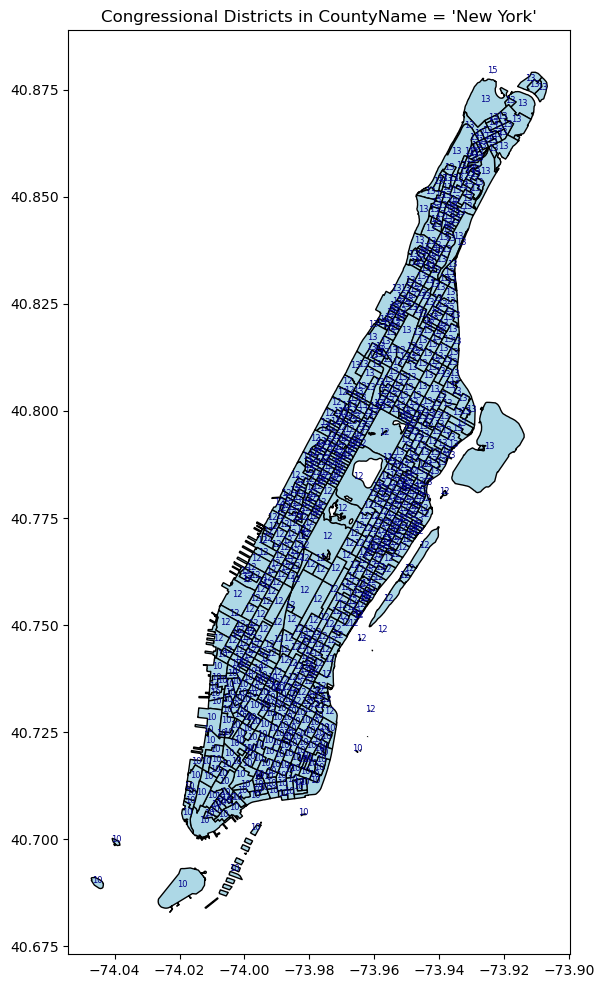

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update with the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate geometries
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid

# Filter for CountyName = 'New York'
new_york_county = gdf[gdf['CountyName'] == 'New York']

# Check for empty results
if new_york_county.empty:
    print("No precincts found for CountyName = 'New York'.")
else:
    # Extract vote columns (for all parties in U.S. House elections, using CONG_DIST)
    vote_columns = [col for col in new_york_county.columns if col.startswith('GCON') and col.endswith(('DEM', 'REP', 'OWRI'))]

    # Add total votes per precinct
    new_york_county['TotalVotes'] = new_york_county[vote_columns].sum(axis=1)

    # Group by CONG_DIST and calculate vote totals
    vote_totals_by_district = new_york_county.groupby('CONG_DIST')['TotalVotes'].sum()

    # Calculate total votes in the county
    total_votes_county = vote_totals_by_district.sum()

    # Calculate proportions for each congressional district
    vote_proportions = (vote_totals_by_district / total_votes_county) * 100

    # Print results
    print(f"Total Votes in CountyName = 'New York': {total_votes_county}")
    print("Vote Proportions by Congressional District:")
    print(vote_proportions)

    # Plot the precincts and display proportional results
    fig, ax = plt.subplots(figsize=(12, 12))
    new_york_county.plot(ax=ax, color='lightblue', edgecolor='black')

    for idx, row in new_york_county.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CONG_DIST at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CONG_DIST']), 
                     fontsize=6, ha='center', color='darkblue')

    plt.title("Congressional Districts in CountyName = 'New York'")
    plt.show()


/var/folders/4w/5mb74rx152dc7knnw3zmr5j00000gn/T/ipykernel_31947/1287606132.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_districts))  # Use 'tab20' colormap
/Users/gvsprudhulamouktik/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


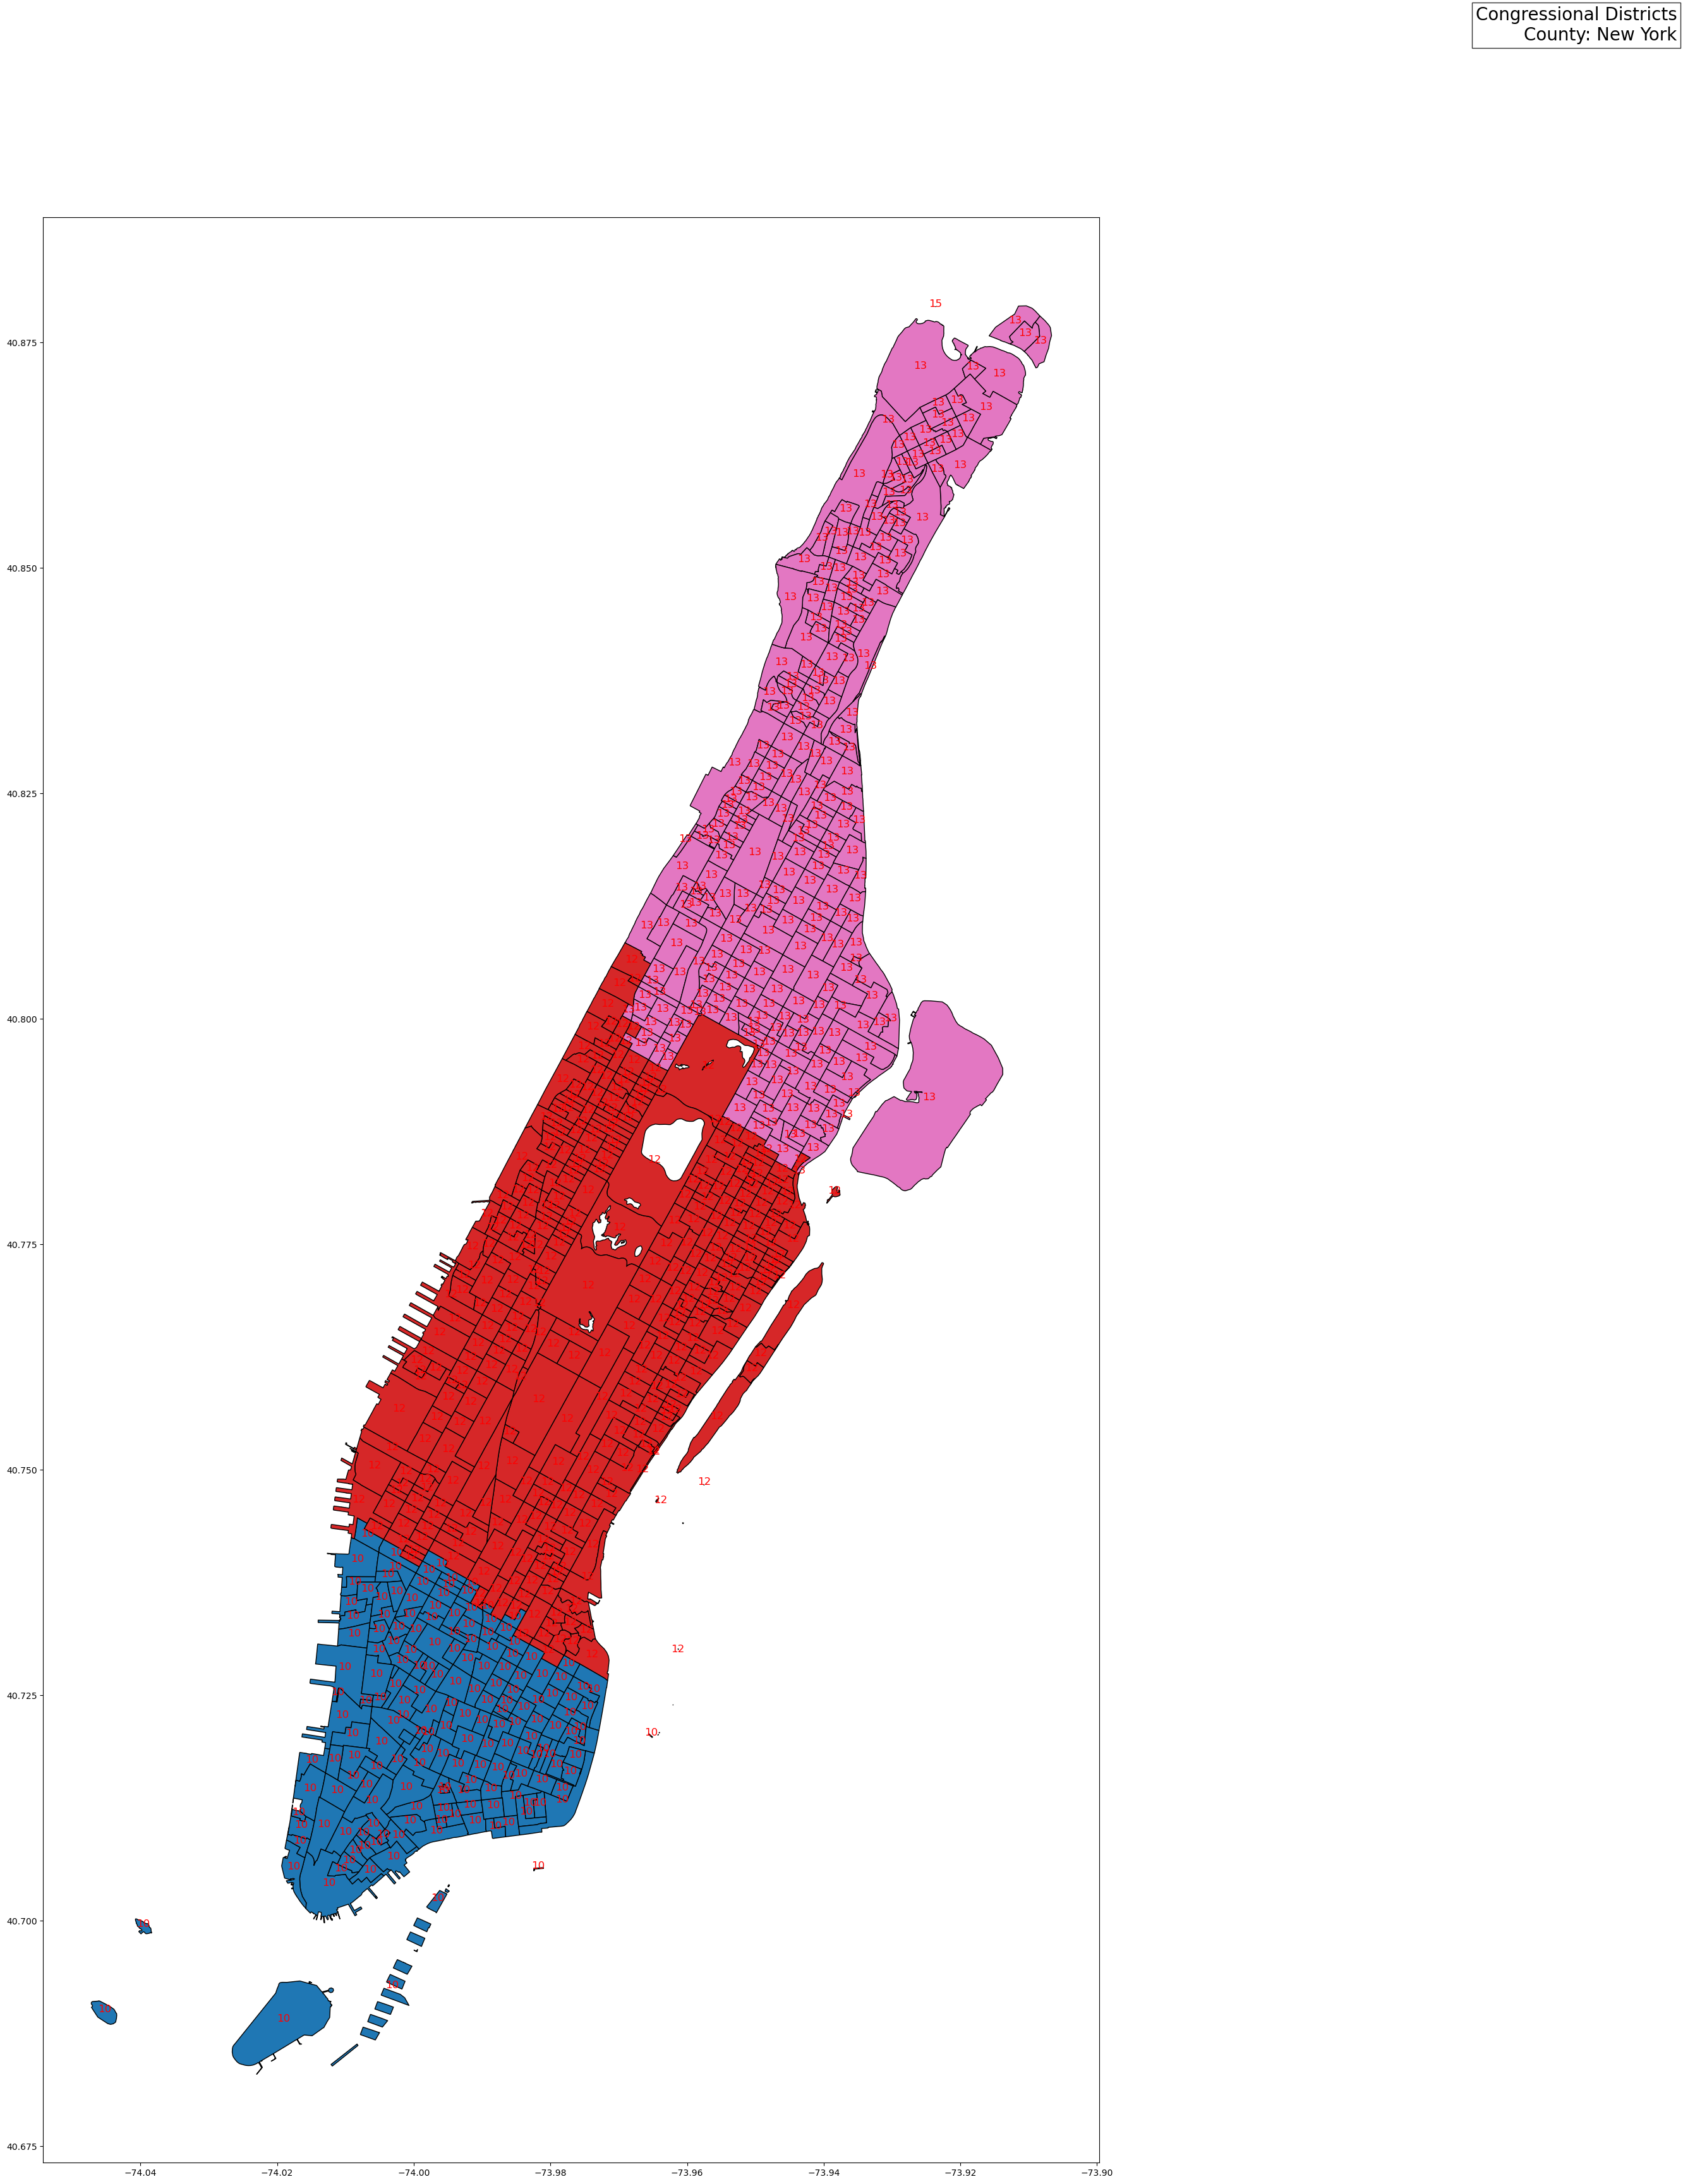

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate geometries
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid

# Filter for CountyName = 'New York'
new_york_county = gdf[gdf['CountyName'] == 'New York']

# Check for empty results
if new_york_county.empty:
    print("No precincts found for CountyName = 'New York'.")
else:
    # Create a categorical colormap
    unique_districts = new_york_county['CONG_DIST'].unique()
    cmap = plt.cm.get_cmap('tab10', len(unique_districts))  # Use 'tab20' colormap
    district_colors = {district: cmap(i) for i, district in enumerate(unique_districts)}

    # Assign colors to each precinct based on 'CONG_DIST'
    new_york_county['color'] = new_york_county['CONG_DIST'].map(district_colors)

    # Plot the precincts with different colors
    fig, ax = plt.subplots(figsize=(40, 40))
    new_york_county.plot(ax=ax, color=new_york_county['color'], edgecolor='black')

    # Add CONG_DIST labels
    for idx, row in new_york_county.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CONG_DIST at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CONG_DIST']), 
                     fontsize=12, ha='center', color='red')

    # Add label at the top-right corner
    plt.text(
        0.95, 0.95,  # Position in relative figure coordinates
        "Congressional Districts\nCounty: New York", 
        fontsize=20, color='black', ha='right', transform=fig.transFigure,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

    plt.show()


/var/folders/4w/5mb74rx152dc7knnw3zmr5j00000gn/T/ipykernel_31947/899215842.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('ocean', len(unique_districts))  # Use 'Set3' colormap
/Users/gvsprudhulamouktik/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


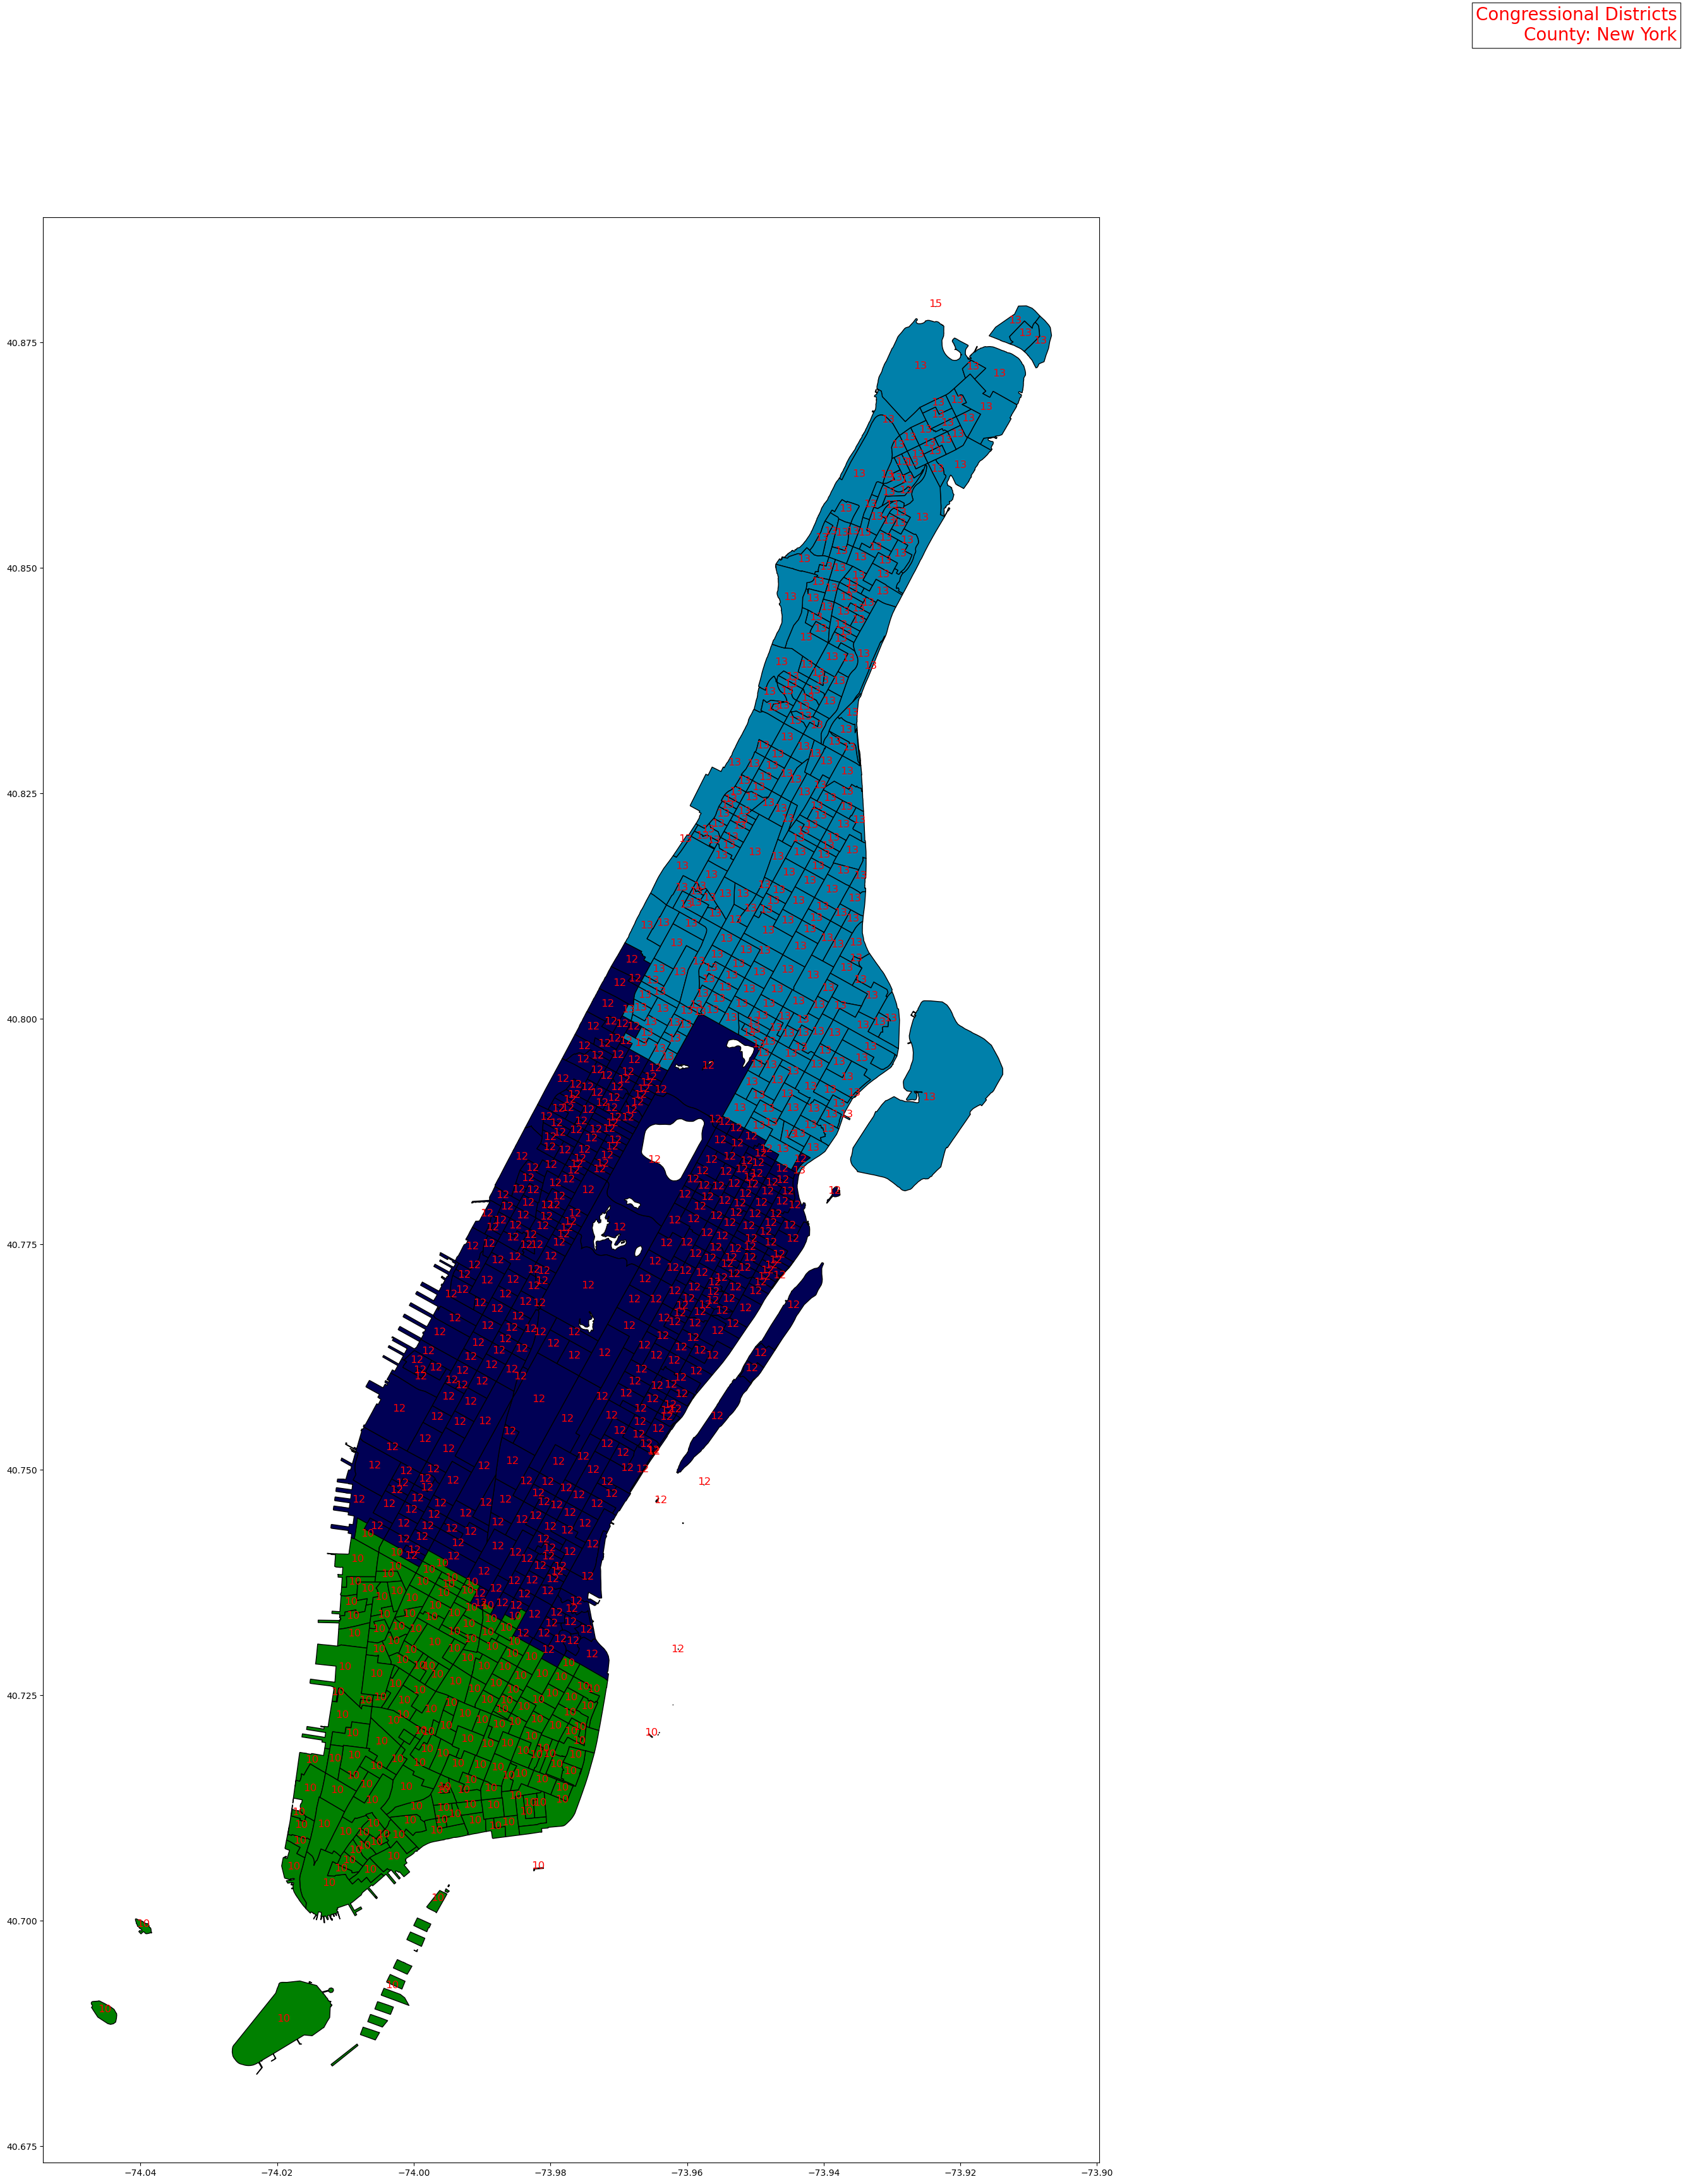

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Correct shapefile path
shapefile_path = "ny_2022_gen_prec.shp"  # Update to the correct path

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Validate geometries
gdf = gdf[gdf.geometry.notnull()]  # Remove rows with null geometries
gdf = gdf[gdf.is_valid]  # Ensure all geometries are valid

# Filter for CountyName = 'New York'
new_york_county = gdf[gdf['CountyName'] == 'New York']

# Check for empty results
if new_york_county.empty:
    print("No precincts found for CountyName = 'New York'.")
else:
    # Create a categorical colormap using 'Set3' for distinct colors
    unique_districts = new_york_county['CONG_DIST'].unique()
    cmap = plt.cm.get_cmap('ocean', len(unique_districts))  # Use 'Set3' colormap
    district_colors = {district: cmap(i) for i, district in enumerate(unique_districts)}

    # Assign colors to each precinct based on 'CONG_DIST'
    new_york_county['color'] = new_york_county['CONG_DIST'].map(district_colors)

    # Plot the precincts with different colors
    fig, ax = plt.subplots(figsize=(40, 40))
    new_york_county.plot(ax=ax, color=new_york_county['color'], edgecolor='black')

    # Add CONG_DIST labels
    for idx, row in new_york_county.iterrows():
        if not row.geometry.is_empty:
            # Get the centroid for labeling
            centroid = row.geometry.centroid
            # Add CONG_DIST at the centroid location
            plt.text(centroid.x, centroid.y, str(row['CONG_DIST']), 
                     fontsize=12, ha='center', color='red')

    # Add label at the top-right corner
    plt.text(
        0.95, 0.95,  # Position in relative figure coordinates
        "Congressional Districts\nCounty: New York", 
        fontsize=20, color='red', ha='right', transform=fig.transFigure,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

    plt.show()
